##**Домашнее задание по теме "Элементарные методы анализа временных рядов"**


**Задание:**

1. Возьмите из из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

**Решение:**

# Импорт библиотек и загрузка данных

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score


In [ ]:
# Скачиваем данные
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
import matplotlib.pyplot as plt

# Отображение данных

In [ ]:
# Принт содержимого каждого DataFrame
print("Sales of Company X:")
print(sales_of_company_x.head(), "\n")

print("Robberies in Boston:")
print(robberies_in_boston.head(), "\n")

print("Airlines Passengers:")
print(airlines_passengers.head(), "\n")

print("Mean Monthly Temperature:")
print(mean_monthly_temp.head(), "\n")

print("Dow Jones Closing:")
print(dowjones_closing.head(), "\n")

print("Female Births:")
print(female_births.head(), "\n")

Sales of Company X:
     Month  Count
0  1965-01    154
1  1965-02     96
2  1965-03     73
3  1965-04     49
4  1965-05     36 

Robberies in Boston:
     Month  Count
0  1966-01     41
1  1966-02     39
2  1966-03     50
3  1966-04     40
4  1966-05     43 

Airlines Passengers:
     Month  Count
0  1949-01    112
1  1949-02    118
2  1949-03    132
3  1949-04    129
4  1949-05    121 

Mean Monthly Temperature:
     Month   Deg
0  1920-01  40.6
1  1920-02  40.8
2  1920-03  44.4
3  1920-04  46.7
4  1920-05  54.1 

Dow Jones Closing:
       Week   Close
0  1971-W27  890.19
1  1971-W28  901.80
2  1971-W29  888.51
3  1971-W30  887.78
4  1971-W31  858.43 

Female Births:
         Date  Count
0  1959-01-01     35
1  1959-01-02     32
2  1959-01-03     30
3  1959-01-04     31
4  1959-01-05     44 



In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

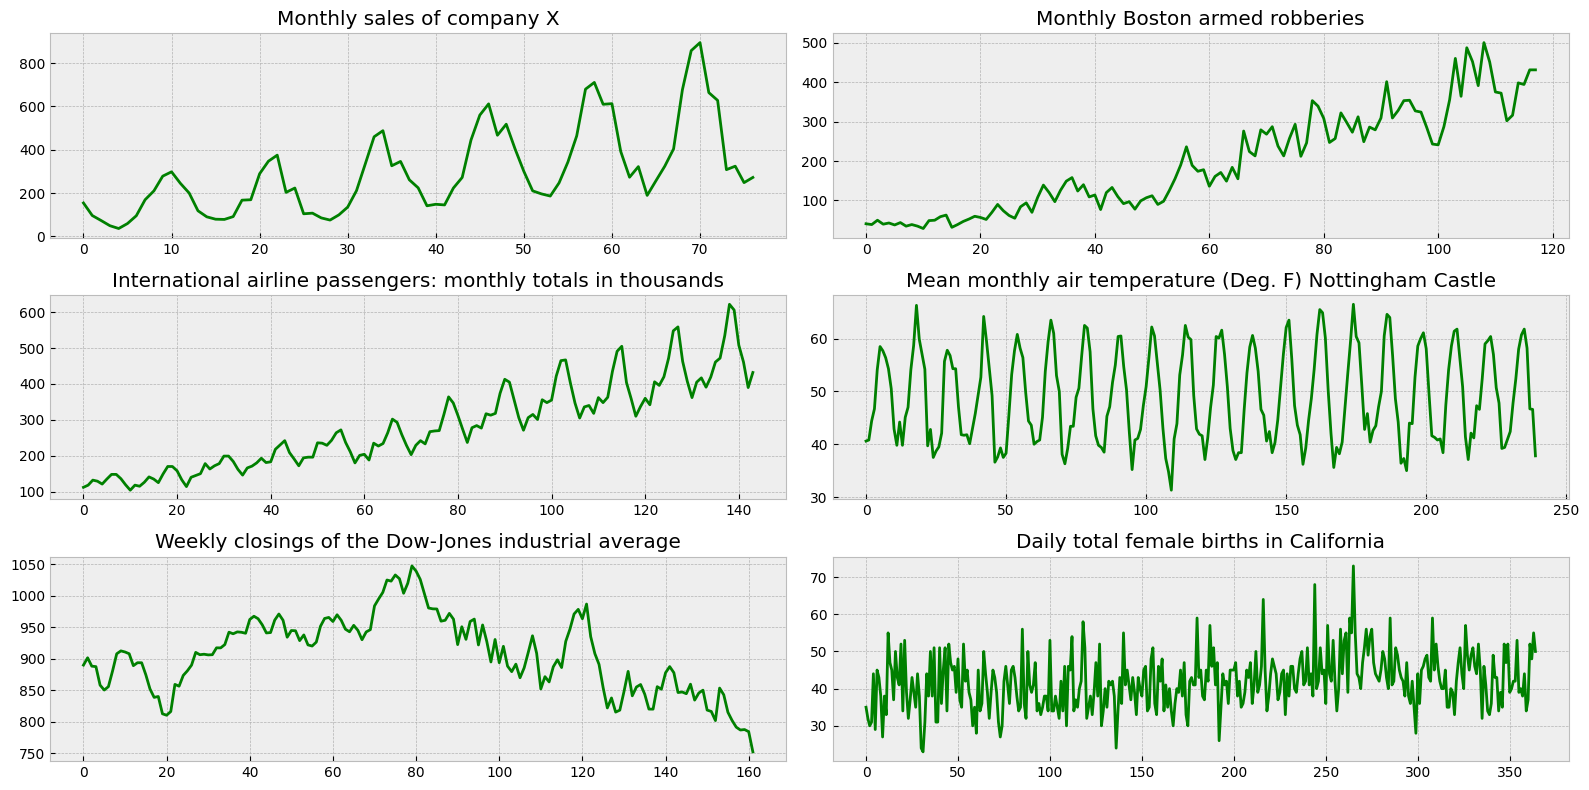

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='green')
        ts_ax.set_title(key)

    plt.tight_layout()

In [ ]:
def analyze_time_series(series, title):
    # Проводим тест Дики-Фуллера для проверки стационарности временного ряда
    adf_test = adfuller(series)
    print(f"{title} ADF Statistic: {adf_test[0]}")
    print(f"{title} p-value: {adf_test[1]}")

    # Оценка результатов теста
    if adf_test[1] < 0.05:
        print(f"{title} стационарен (отклоняем нулевую гипотезу)")
    else:
        print(f"{title} нестационарен (не удается отклонить нулевую гипотезу)")
# Применяем функцию для каждого временного ряда в словаре
for key, series in all_series.items():
    analyze_time_series(series, key)
    print()

Monthly sales of company X ADF Statistic: 0.6547150829524446
Monthly sales of company X p-value: 0.9888894205170052
Monthly sales of company X нестационарен (не удается отклонить нулевую гипотезу)

Monthly Boston armed robberies ADF Statistic: 1.001102140245781
Monthly Boston armed robberies p-value: 0.994277563805723
Monthly Boston armed robberies нестационарен (не удается отклонить нулевую гипотезу)

International airline passengers: monthly totals in thousands ADF Statistic: 0.8153688792060498
International airline passengers: monthly totals in thousands p-value: 0.991880243437641
International airline passengers: monthly totals in thousands нестационарен (не удается отклонить нулевую гипотезу)

Mean monthly air temperature (Deg. F) Nottingham Castle ADF Statistic: -3.2554924030863366
Mean monthly air temperature (Deg. F) Nottingham Castle p-value: 0.016989030222608604
Mean monthly air temperature (Deg. F) Nottingham Castle стационарен (отклоняем нулевую гипотезу)

Weekly closings o

В качестве стационарного ряда рассмотрим Daily total female births in California, в качестве нестационарного - International airline passengers.

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='grey', label='Or', linewidth=4.0)
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


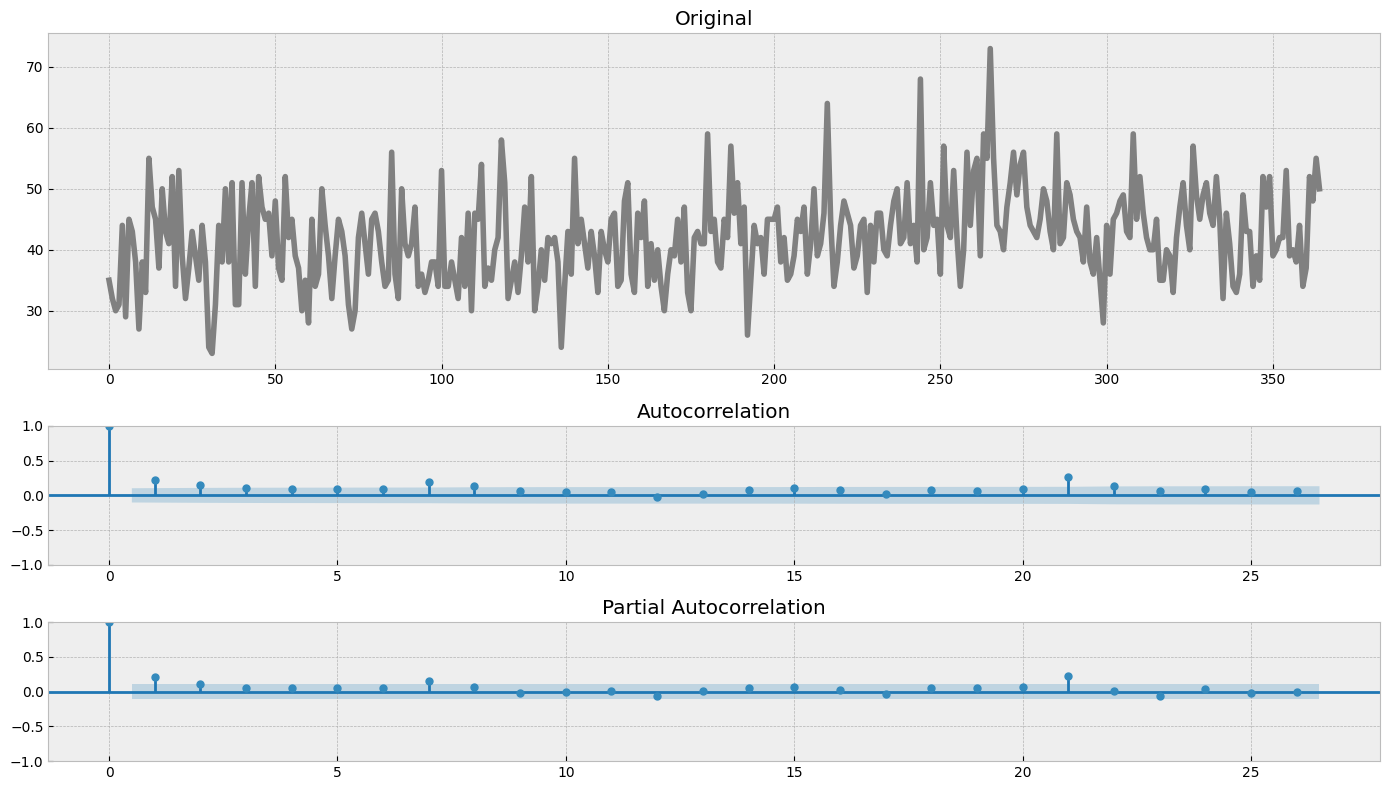

In [ ]:
tsplot(all_series["Daily total female births in California"])

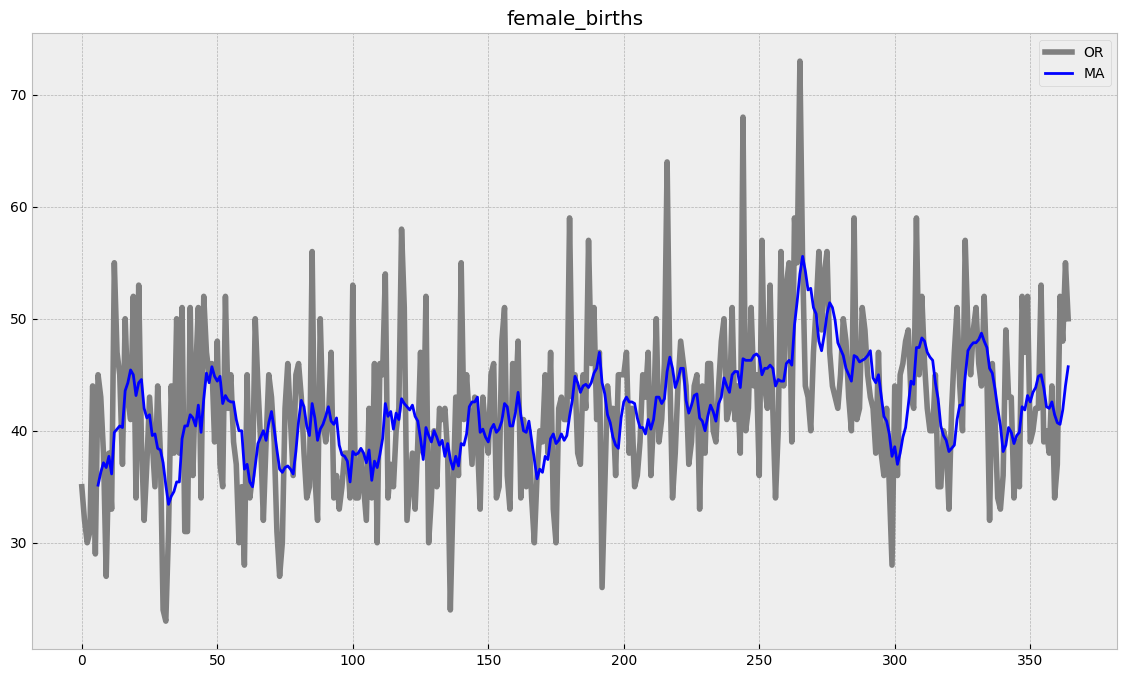

In [ ]:
series = female_births['Count']

# MA - скользящее среднее
ma=series.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.legend()

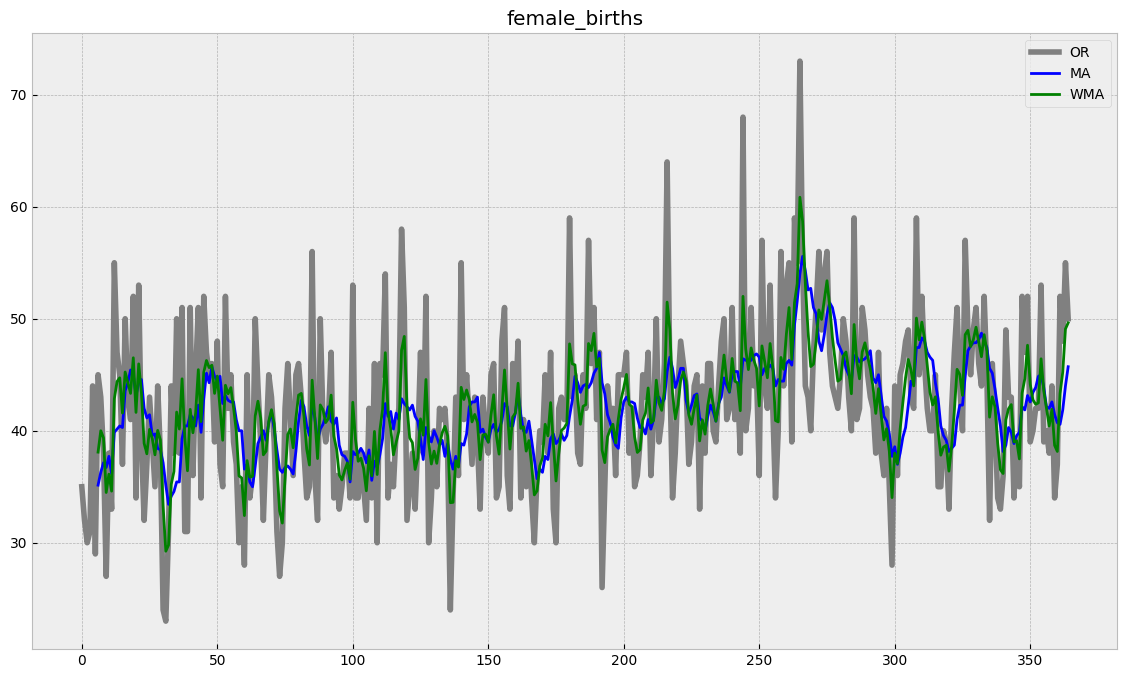

In [ ]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = series.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

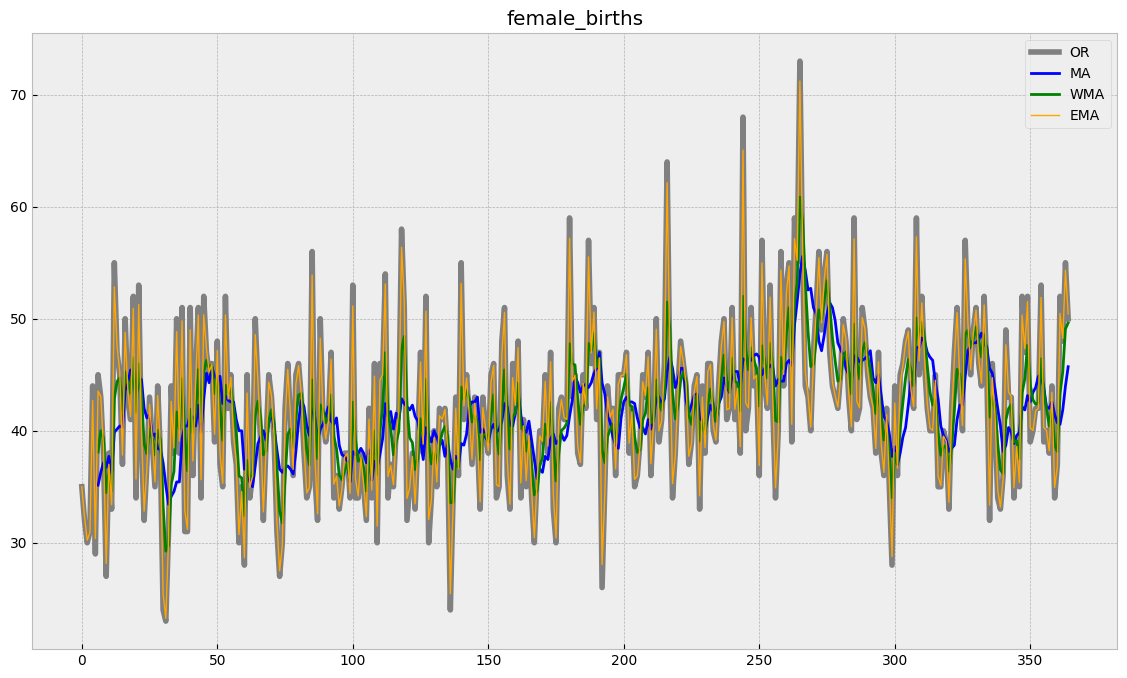

In [ ]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series, 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.legend()

In [ ]:
# Подбор параметров модели
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train, val = series[:train_size], series[train_size:]

def mse_cross_val(X,):
    alpha = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []
    k=0
    for train_split, test_split in split.split(series):

        result = exponential_moving_average(train_split, alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=np.array([0.3]), method="L-BFGS-B", bounds = ((0, 1),))

alpha_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 8281.0
        x: [ 1.000e+00]
      nit: 1
      jac: [-1.820e+02]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


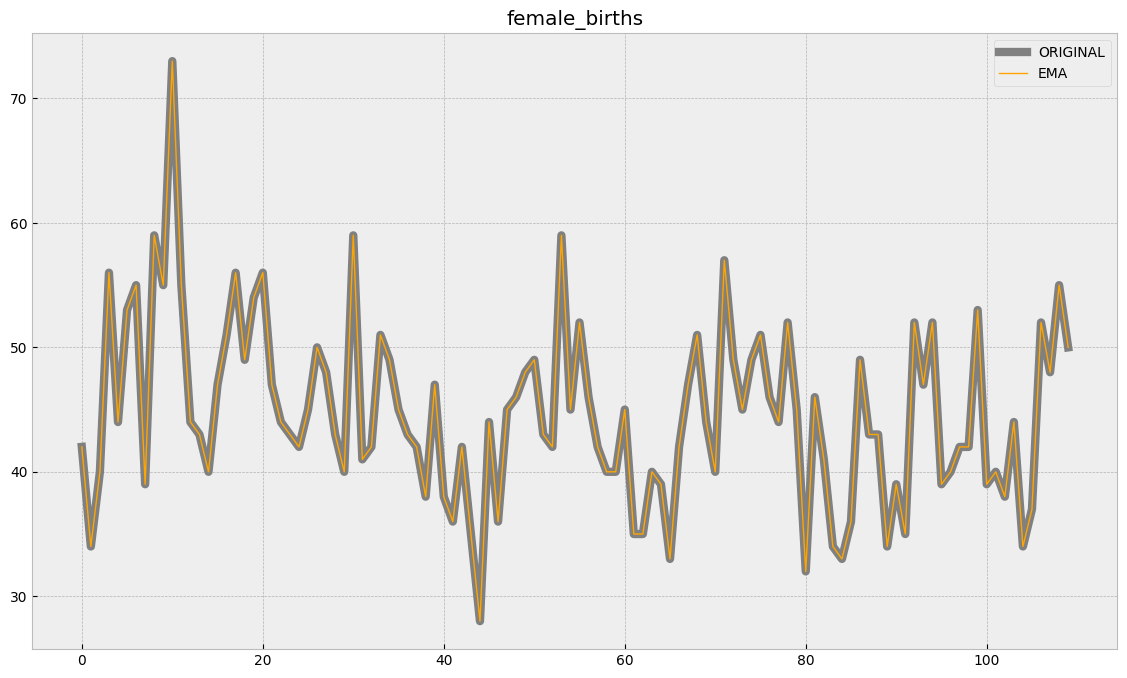

In [ ]:
# Использование новых параметров в тестовых данных
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
ema = exponential_moving_average(val, 1.0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(val, color='grey',label='ORIGINAL', linewidth='6')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.legend()

In [ ]:
# Продуктивность модели
r2_score(y_pred=ema, y_true=val)

1.0

Модель переобучилась.

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


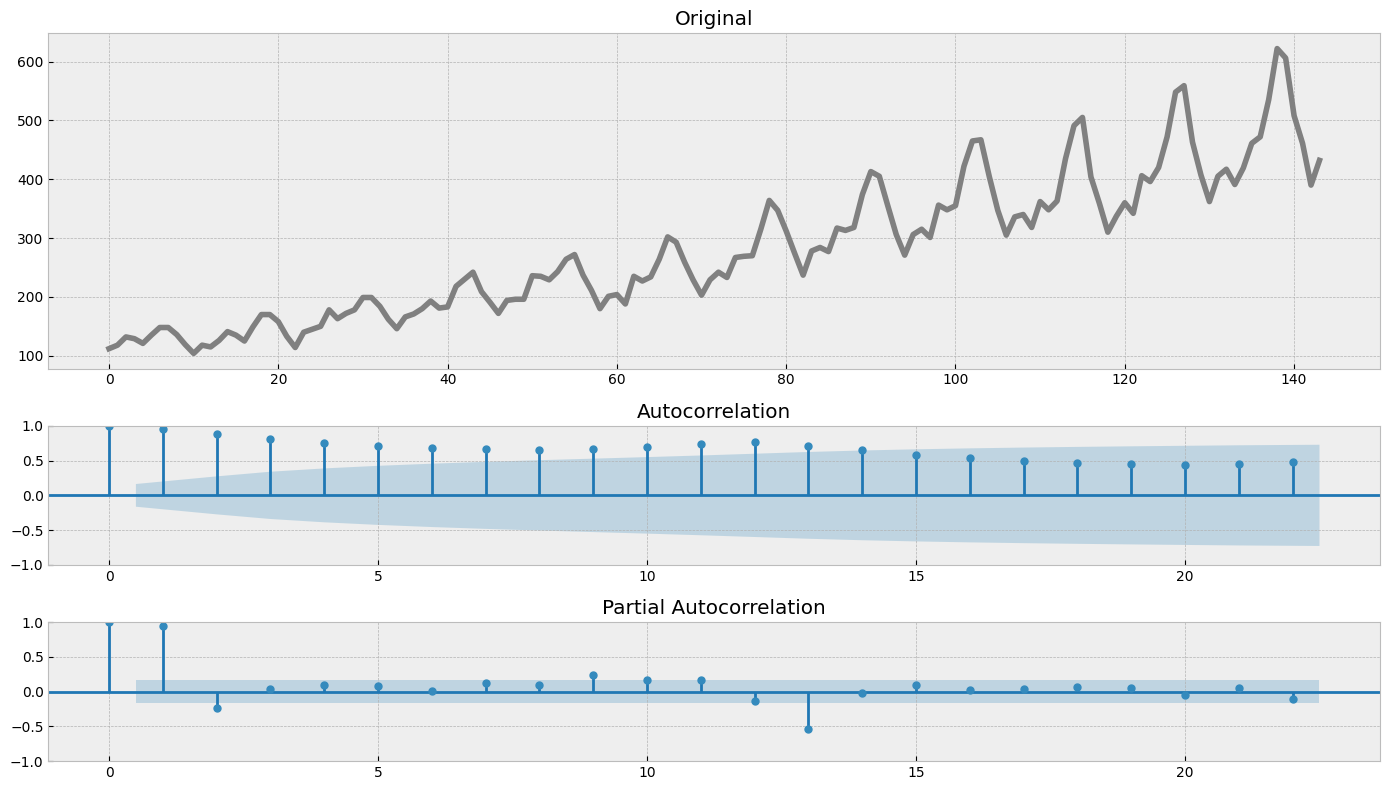

In [ ]:
tsplot(airlines_passengers["Count"])

В качестве нестационарного рассмотрим - International airline passengers.

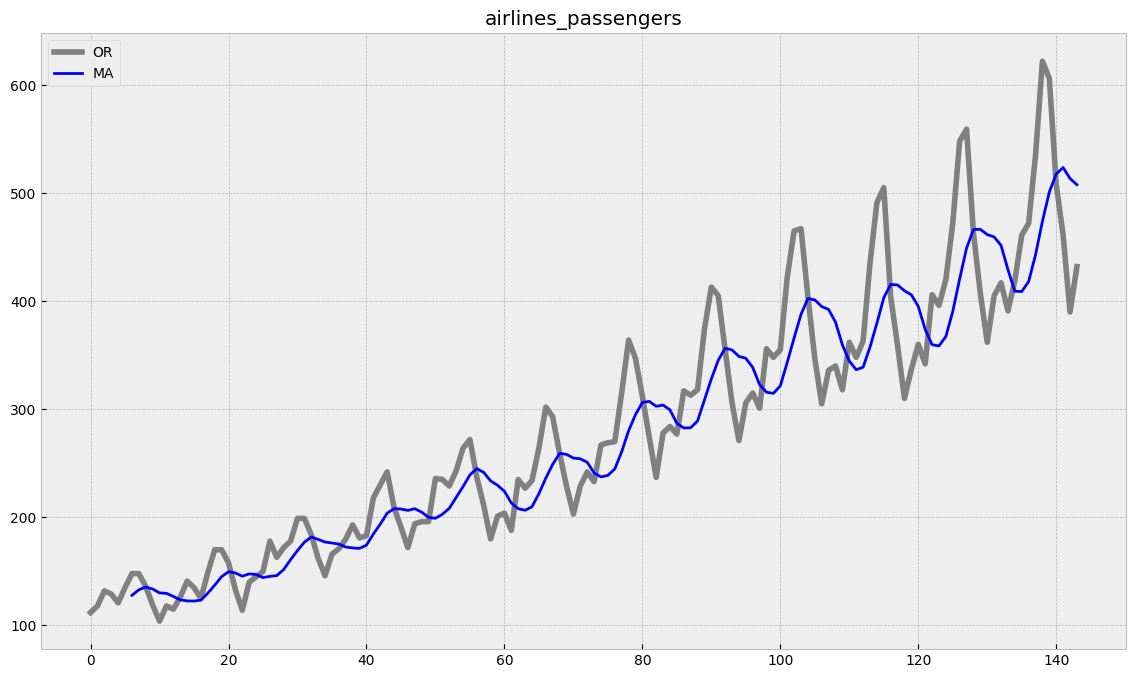

In [ ]:
# MA - скользящее среднее
series = airlines_passengers['Count']

ma=series.rolling(7).mean()
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.legend()


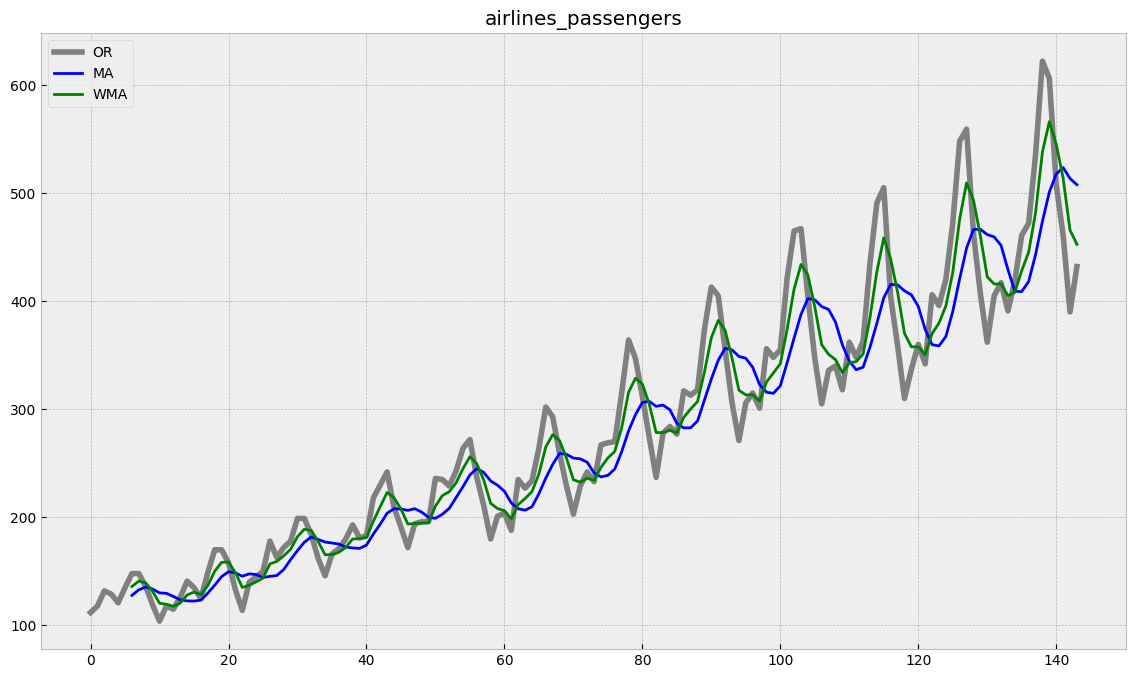

In [ ]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = airlines_passengers["Count"].rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='grey',label='OR', linewidth='4' )
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

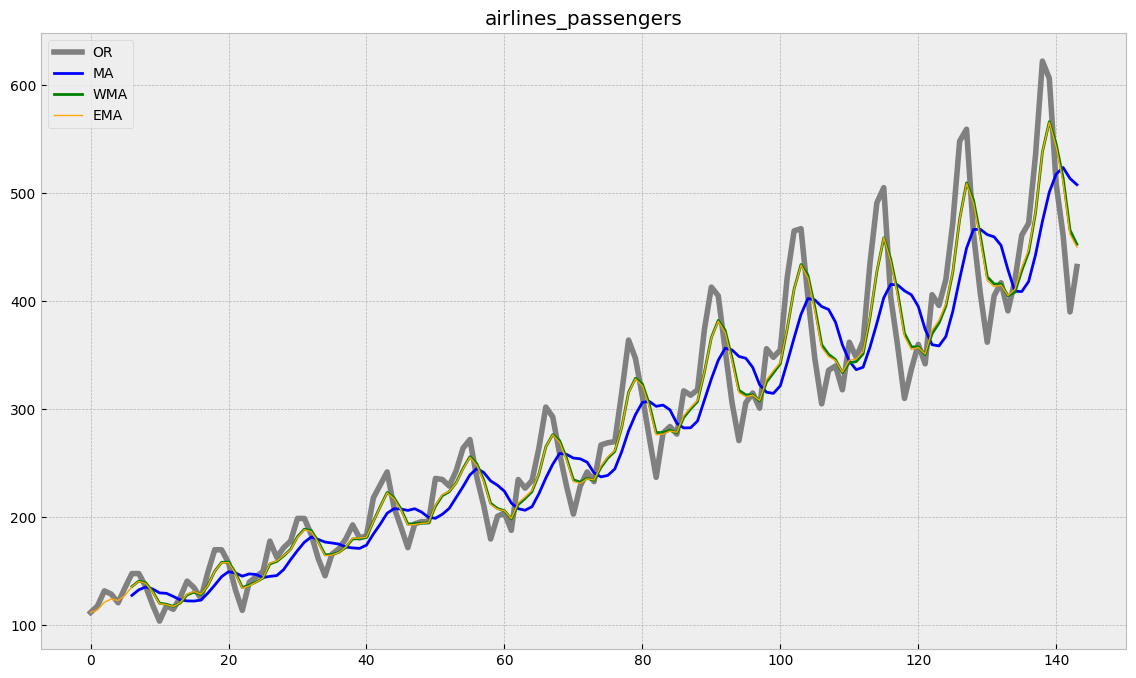

In [ ]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

series = airlines_passengers["Count"]
ema = exponential_moving_average(series, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series2, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.legend()

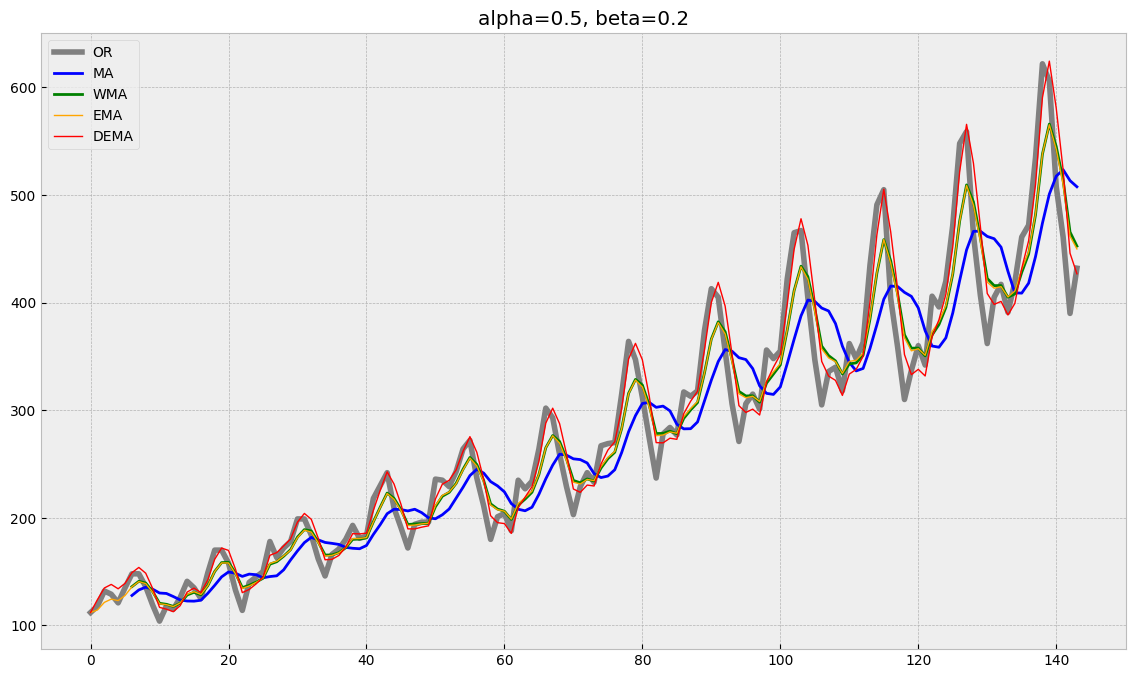

In [ ]:
# DEMA - двойное экспоненциальное сглаживание

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.5
beta=0.2
series = airlines_passengers["Count"]
dema = double_ema(series, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series2, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.plot(dema, color='red', linewidth='1', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

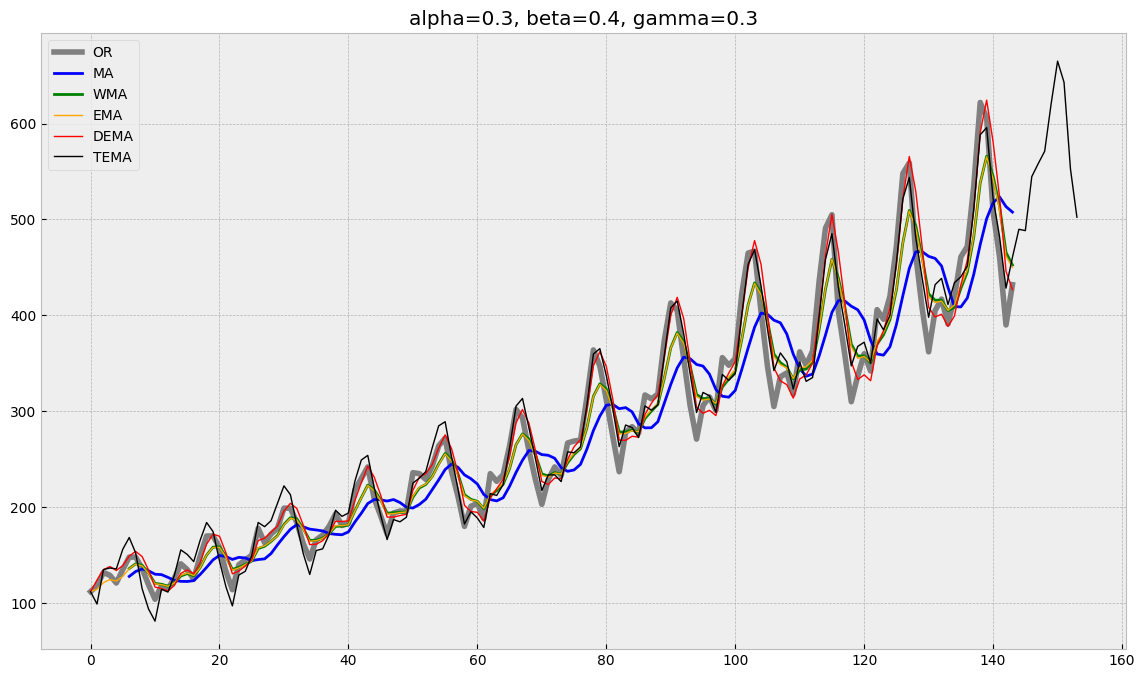

In [ ]:
# tema - Хольт-Винтерс (для учёта сезонности)

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

series = airlines_passengers["Count"]

tema = triple_exponential_smoothing(series, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.plot(dema, color='red', linewidth='1', label='DEMA')
    plt.plot(tema, color='black', linewidth='1', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()


In [ ]:
# Подберем параметры
series = airlines_passengers["Count"]
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train = series[:train_size]
val = series[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(airlines_passengers["Count"]):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2491208619682703e-07
        x: [ 4.306e-02  2.606e-01  9.711e-01]
      nit: 42
      jac: [ 2.753e-05 -1.584e-05  3.377e-05]
     nfev: 256
     njev: 64
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


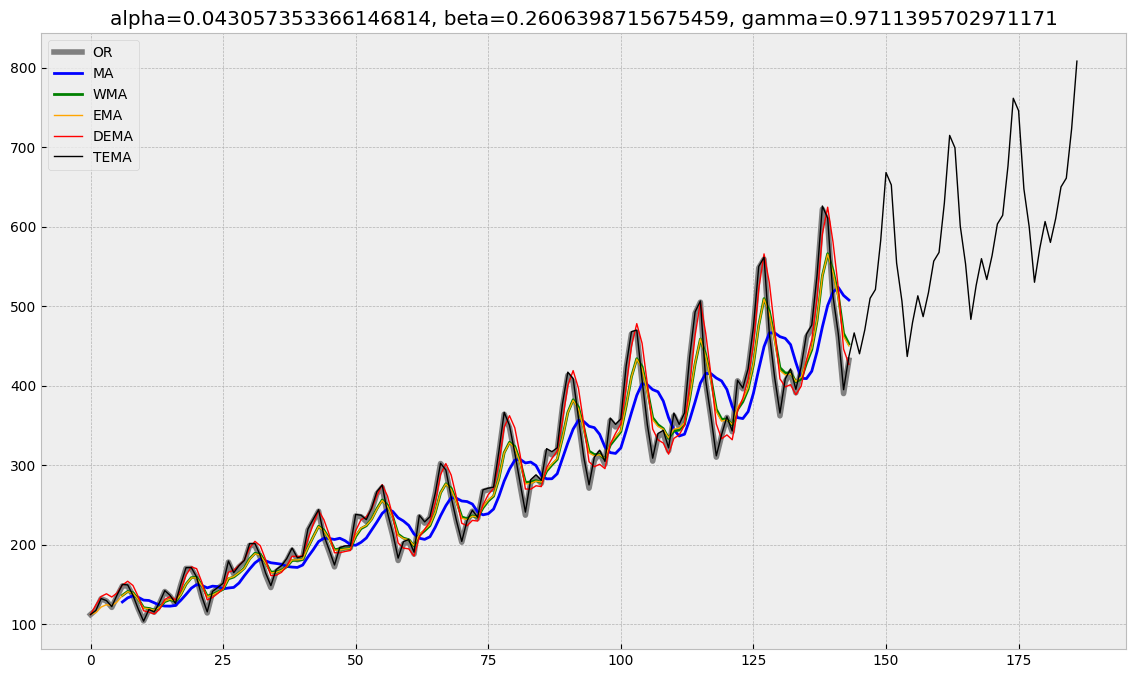

In [ ]:
# Применим полученные параметры
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
tema = triple_exponential_smoothing(series, 12, alpha_opt, beta_opt, gamma_opt, len(val))

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='grey',label='OR', linewidth='4')
    plt.plot(ma, color='blue', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='1', label='EMA')
    plt.plot(dema, color='red', linewidth='1', label='DEMA')
    plt.plot(tema, color='black', linewidth='1', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

Самую высокую точность показывает модель TEMA, поскольку отражает, как тренд, так и сезонность временного ряда.